In [37]:
conda install -c conda-forge lmfit

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
/ 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from numba import jit
import arviz as az

# NEED TO INSTALL LMFIT
import lmfit
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import theano
import theano.tensor as t
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

ModuleNotFoundError: No module named 'lmfit'

The purpose of this function is to model different social distancing policies and allow them to be softened as time goes on. To model with social distancing remaining in place indefinitely, let $R_{0_l} = R_{0_h}$.

In [91]:
def R_0(t):
    R_0_s = 1
    R_0_l = 11
    R_0_h = 11
    k_1 = 0.4
    k_2 = 0.1
    x_0 = 20
    x_1 = 150
    
    R_0 = (R_0_s - R_0_l) / (1 + np.exp(-k_1 * (-t + x_0))) + (R_0_h - R_0_l) / (1 + np.exp(-k_2 * (t - x_1))) + R_0_l
    return R_0

In [92]:
x = np.linspace(0, 200, 50)

In [93]:
y = np.apply_along_axis(R_0(x), 0, x)

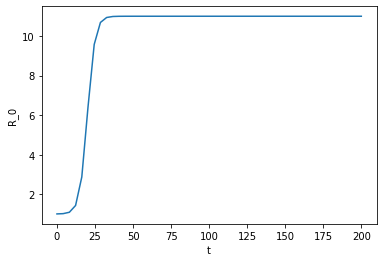

In [94]:
plt.plot(x, y)
plt.xlabel("t")
plt.ylabel("R_0");

# Create an SIR Model

Based on: https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4

## Plotting

In [2]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

## Create Baseline Model

### Read in Data

In [3]:
# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

### Create Model

In [4]:
#   Number of days from infected to critical: 12 (→rate: 1/12)
#   Number of days from critical to dead: 7.5 (→rate: 1/7.5)
#   Number of days from critical to recovered: 6.5 (→rate: 1/6.5)

days_to_critical = 12.0
days_C_to_D = 7.5
days_C_to_R = 6.5

def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/days_to_critical * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/days_to_critical * p_I_to_C * I - 1/days_C_to_D * p_C_to_D * C - (1 - p_C_to_D) * 1/days_C_to_R * C
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/days_C_to_R * C
    dDdt = 1/days_C_to_D * p_C_to_D * C
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [5]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

percentage going to ICU: 5.0; percentage dying in ICU: 60.0


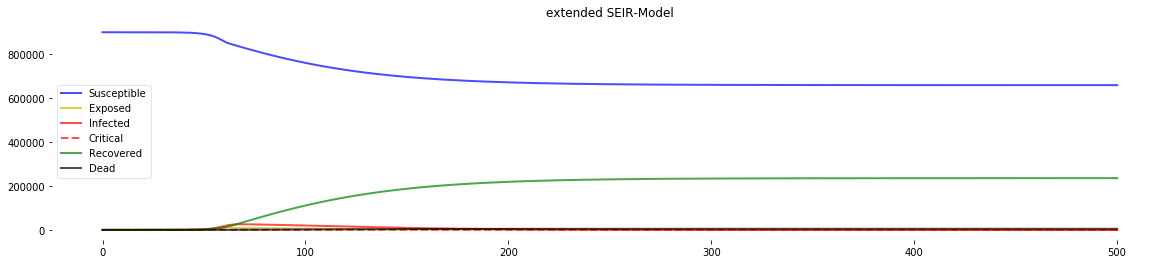

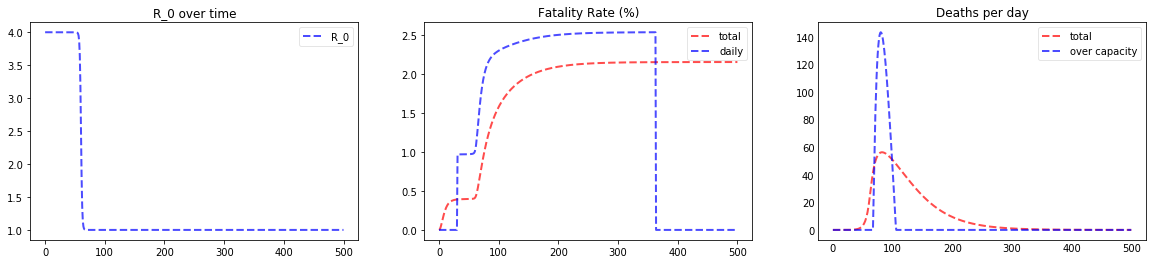

In [6]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

### Fit Model to US Data

In [96]:
# parameters
data = covid_data[covid_data["Location"] == "US"]["Value"].values[::-1]
agegroups = agegroup_lookup["US"]
beds_per_100k = beds_lookup["United States"]
outbreak_shift = 0
# form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}

NameError: name 'covid_data' is not defined

In [97]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [98]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "least_squares"

In [99]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)

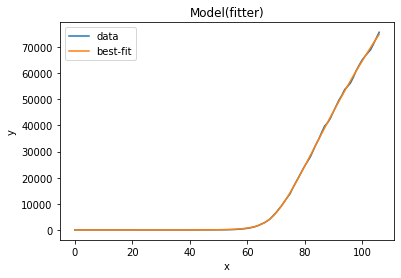

In [100]:
result.plot_fit(datafmt="-");

In [101]:
result.best_values

{'R_0_start': 4.999999862276224,
 'k': 1.1875959461566046,
 'x0': 67.01489149023851,
 'R_0_end': 0.8154395414633988,
 'prob_I_to_C': 0.08962814204738823,
 'prob_C_to_D': 0.2058535588184666,
 's': 0.003}

Prediction for United States
percentage going to ICU: 8.962814204738823; percentage dying in ICU: 20.58535588184666


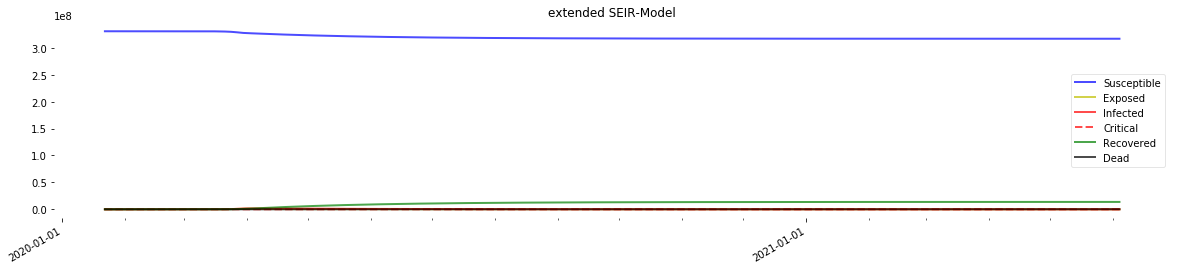

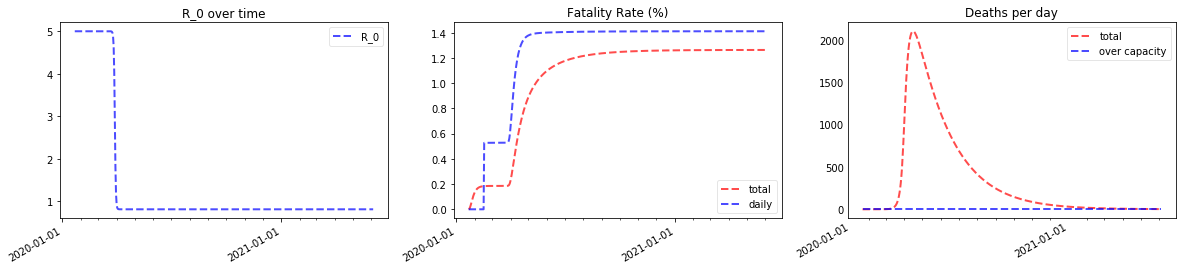

In [102]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for United States")
fit_model = Model(full_days, agegroup_lookup["US"], beds_lookup["United States"], **result.best_values)
plotter(*fit_model, x_ticks=x_ticks);

In [103]:
# final death count
fit_model[6][-1]

175187.98033742068

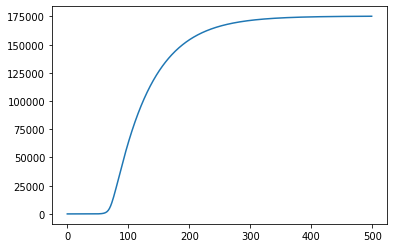

In [104]:
plt.plot(fit_model[6])

# TODO: Next Steps

1) Model $R_0$ using mobility, temperature, test availability, and number of confirmed tests

2) Update parameters to reflect current literature

3) Incoprorate uncertainty into parameter estimates (can do using lmfit)

4) Examine what happens when mobility increases. How does it affect our projections?

## Bayesian Model Fitting

For an example of how to use `DifferentialEquations`, refer to: https://docs.pymc.io/notebooks/ODE_API_introduction.html

In [ ]:
days_to_critical = 12.0
days_C_to_D = 7.5
days_C_to_R = 6.5

def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/days_to_critical * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/days_to_critical * p_I_to_C * I - 1/days_C_to_D * p_C_to_D * C - (1 - p_C_to_D) * 1/days_C_to_R * C
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/days_C_to_R * C
    dDdt = 1/days_C_to_D * p_C_to_D * C
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [23]:
def SIR(y, t, p):
#     S, E, I, C, R, D = y
#     p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma = p
#        0         1      2  3       4          5      6     7

    days_to_critical = 12.0
    days_C_to_D = 7.5
    days_C_to_R = 6.5
    N = 1.0
    
    beta = ((p[4]-p[5]) / (1 + np.exp(-p[2]*(-t+p[3]))) + p[5]) * p[6]
    dSdt = -beta * y[2] * y[0] / N
    dEdt = beta * y[2] * y[0] / N - p[7] * y[1]
    dIdt = p[7] * y[1] - 1/days_to_critical * p[0] * y[2] - p[6] * (1 - p[0]) * y[2]
    dCdt = 1/days_to_critical * p[0] * y[2] - 1/days_C_to_D * p[1] * y[3] - (1 - p[1]) * 1/days_C_to_R * y[3]
    dRdt = p[6] * (1 - p[0]) * y[2] + (1 - p[1]) * 1/days_C_to_R * y[3]
    dDdt = 1/days_C_to_D * p[1] * y[3]
    
    return [dSdt, dEdt, dIdt, dCdt, dRdt, dDdt]

R_nought = beta / gamma

In [25]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.array(x_data),
    n_states=6, n_theta=8,
    t0=0
)

with pm.Model() as model:
    sd = pm.HalfCauchy('sigma', 1)
    
    p_I_to_C = pm.Beta("p_I_to_C", 5, 1)
    p_C_to_D = pm.Beta("p_C_to_D", 5, 1)
    # p_I_to_C = pm.Uniform("p_I_to_C", 0, 0.2)
    # p_C_to_D = pm.Uniform("p_C_to_D", 0, 0.2)
    
    # k = pm.Bound(pm.Lognormal, upper=7)("k", mu=0, sd=1) # add upper bound of 5 or so
    k = 4
    # x_0 = pm.Bound(pm.Lognormal, upper=len(x_data))("x_0", mu=pm.math.log(90), sd=1)
    x_0 = 90
    R_0_start = pm.Bound(pm.Normal, lower=1, upper=5)("R_0_s", mu=2, sd=2)
    R_0_end = pm.Bound(pm.Normal, lower=0, upper=5)("R_0_e", mu=1, sd=2)
    # TODO: introduce bounds for k
    # TODO: Try moving beta here and make it deterministic using logit
    # TODO: Scale these, ie 1 / X = what we have
    
    # best estimates from papers
    gamma = 1.0/9.0 
    sigma = 1.0/3.0
    
    N = sum(agegroup_lookup["US"])
    
    y0 = [0.99, 0.01, 0.0, 0.0, 0.0, 0.0]
    sir_curves = sir_model(y0=y0, theta=[p_I_to_C, p_C_to_D, k, x_0, R_0_start, R_0_end, gamma, sigma])
    
    Y = pm.Normal('Y', mu=sir_curves[:,5], sd=sd, observed=y_data/N)
    trace = pm.sample(1000, tune=500)  

//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file

ValueError: Not enough samples to build a trace.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

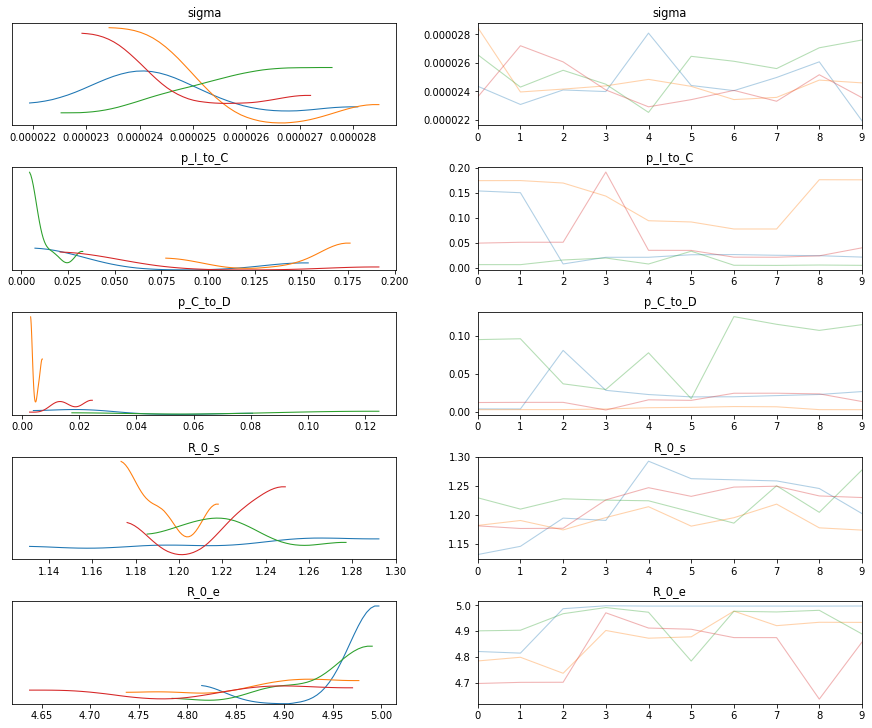

In [50]:
pm.traceplot(trace);

## Try using a smaller model

Alpha: is the conversion parameter for exposed individuals that transformed into infected ones

Beta: is the conversion parameter due to interaction between a susceptible individual with an infected one

Gamma: is the conversion rate parameter for susceptible individuals that interact with exposed individuals and then become exposed

Zeta: is the conversion parameter related to the recovery rate

Delta: is the mortality rate for the disease

R_0: beta / zeta

In [20]:
def SEIRD(y, t, p):
    # S, E, I, R, D = y
    # alpha, beta, gamma, zeta, delta = p
    S_prime = - p[1] * y[0] * y[2] - p[2] * y[1] * y[0]
    E_prime = p[1] * y[0] * y[2] - p[0] * y[1] + p[2] * y[1] * y[0]
    I_prime = p[0] * y[1] - p[3] * y[2] - p[4] * y[2]
    R_prime = p[3] * y[2]
    D_prime = p[4] * y[2]
    return [S_prime, E_prime, I_prime, R_prime, D_prime]

In [26]:
seir_model = DifferentialEquation(
    func=SEIRD,
    times=np.array(x_data),
    n_states=5, n_theta=5,
    t0=0
)

with pm.Model() as model2:
    sd = pm.HalfCauchy('sigma', 1)
    
    # alpha = pm.Uniform("alpha", 0, 0.1)
    alpha = 1 / 3
    beta = pm.Uniform("beta", 0, 0.5)
    gamma = pm.Uniform("gamma", 0, 0.5)
    zeta = 1 / 14
    # zeta = pm.Uniform("zeta", 0, 0.1)
    delta = pm.Uniform("delta", 0, 0.1)
    
    # From before: 
    # also try alpha=1/4, zeta = 1/14, gamma=1/9
    # gamma = 1 / D (D is days with infection)
    # alpha = 1 / I (I is incubation days)
    
    N = sum(agegroup_lookup["US"])
    
    y0 = [0.99, 0.01, 0.0, 0.0, 0.0]
    sir_curves = seir_model(y0=y0, theta=[alpha, beta, gamma, zeta, delta])
    
    Y = pm.Normal('Y', mu=sir_curves[:,4], sd=sd, observed=y_data / N)
    trace = pm.sample(200, tune=100)  

//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file

In [39]:
with model2:
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

100%|██████████| 800/800 [02:34<00:00,  5.18it/s]


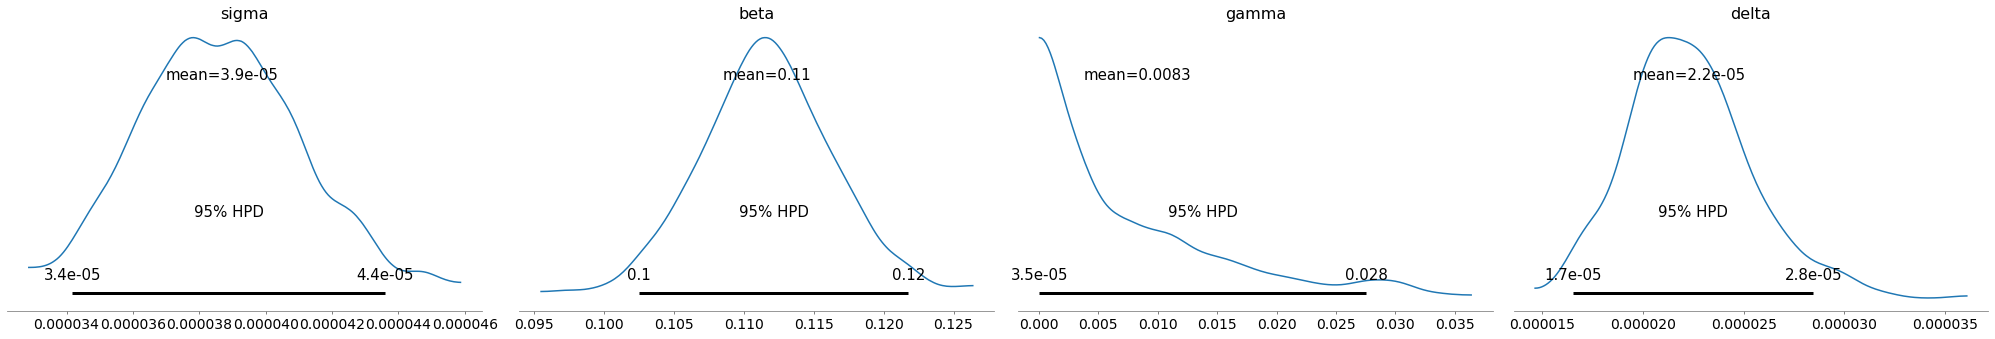

In [40]:
az.plot_posterior(data,round_to=2, credible_interval=0.95);

//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

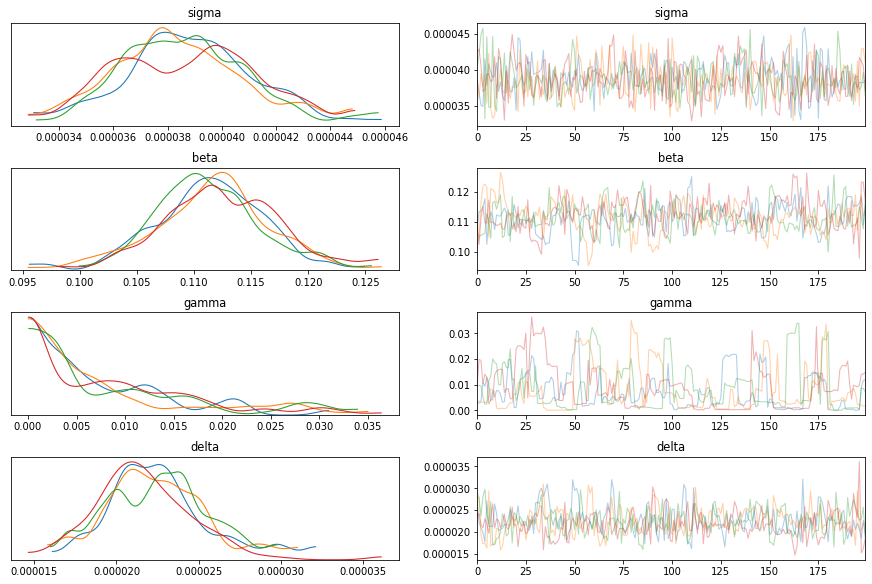

In [27]:
pm.traceplot(trace);

From this, we estimate an $R_0$ between 1.4 and 1.68 using the 95% credible interval for $\beta$ and the value for $\zeta$.

## Stochastic ODE Model

From https://arxiv.org/pdf/1903.00423.pdf

Using simple SEIR model

In [ ]:
with pm.Model() as model2:
    # ...

# Can we make this faster?

The above implementation seems really slow. Try implementing https://www.kaggle.com/volpatto/covid-19-study-with-epidemiology-models as a way to solve the differential equations.

In [105]:
@jit(nopython=True)
def SIR_model(y, t, p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma):
#     S, E, I, C, R, D = y
#    p = np.array([p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma]).astype("float64")
#        0         1      2  3       4          5      6     7

    days_to_critical = 12.0
    days_C_to_D = 7.5
    days_C_to_R = 6.5
    N = 1.0
    
    beta = ((R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end) * gamma
    
    S, E, I, C, R, D = y

    dSdt = -beta * I * S / N
    dEdt = beta * I * S / N - sigma * E
    dIdt = sigma * E - 1/days_to_critical * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/days_to_critical * p_I_to_C * I - 1/days_C_to_D * p_C_to_D * C - (1 - p_C_to_D) * 1/days_C_to_R * C
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/days_C_to_R * C
    dDdt = 1/days_C_to_D * p_C_to_D * C
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [106]:
def seir_ode_solver(y0, t, p_I_to_C, p_C_to_D, gamma, sigma, k=4, x0=100, R_0_start=3, R_0_end=1):
    solution_ODE = odeint(SIR_model, y0, t, args=(p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma))
    
    return solution_ODE

In [107]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dvector])
def seir_ode_solver_wrapper(x_data, f_observations, initial_conditions, p_I_to_C, p_C_to_D, R_0_start, R_0_end, gamma=1/9, sigma=1/3, k=4, x0=90):
    
    y_model = seir_ode_solver(initial_conditions, x_data, p_I_to_C, p_C_to_D, gamma, sigma, k, x0, R_0_start, R_0_end)
    simulated_ode_solution = y_model.T
    _, _, _, _, _, simulated_deaths = simulated_ode_solution

    return simulated_deaths

In [108]:
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    sd = pm.HalfCauchy('sigma', 1)
    p_I_to_C = pm.Beta("p_I_to_C", 5, 1)
    p_C_to_D = pm.Beta("p_C_to_D", 5, 1)
    # p_I_to_C = pm.Uniform("p_I_to_C", 0, 0.2)
    # p_C_to_D = pm.Uniform("p_C_to_D", 0, 0.2)
    
    # k = pm.Bound(pm.Lognormal, upper=7)("k", mu=0, sd=1) # add upper bound of 5 or so
    # k = 4.0
    # x_0 = pm.Bound(pm.Lognormal, upper=len(x_data))("x_0", mu=pm.math.log(90), sd=1)
    # x0 = 90.0
    R_0_start = pm.Bound(pm.Normal, lower=1)("R_0_s", mu=2, sd=2)
    R_0_end = pm.Bound(pm.Normal, lower=0)("R_0_e", mu=1, sd=2)
    
    # best estimates from papers
    # gamma = 1.0/9.0
    # sigma = 1.0/3.0
    
    N = sum(agegroup_lookup["US"])

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('seir_model', seir_ode_solver_wrapper(
        theano.shared(x_data.astype("float64")), 
        theano.shared(y_data / N), 
        theano.shared(np.array([0.99, 0.01, 0.0, 0.0, 0.0, 0.0])),
        p_I_to_C, p_C_to_D, R_0_start, R_0_end
        )
    )

    # Variance related to population fraction amount! Let's assume a variance of 100 individuals, since there are cases that have been not tracked
#     variance = (100 / N) * (100 / N)
#     standard_deviation = np.sqrt(variance)


    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=sd, observed=y_data/N)

    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
    seir_trace = pm.sample(20000, tune=10000, chains=4, cores=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [R_0_e]
>Metropolis: [R_0_s]
>Metropolis: [p_C_to_D]
>Metropolis: [p_I_to_C]
>Metropolis: [sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [11:21<00:00, 176.19draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

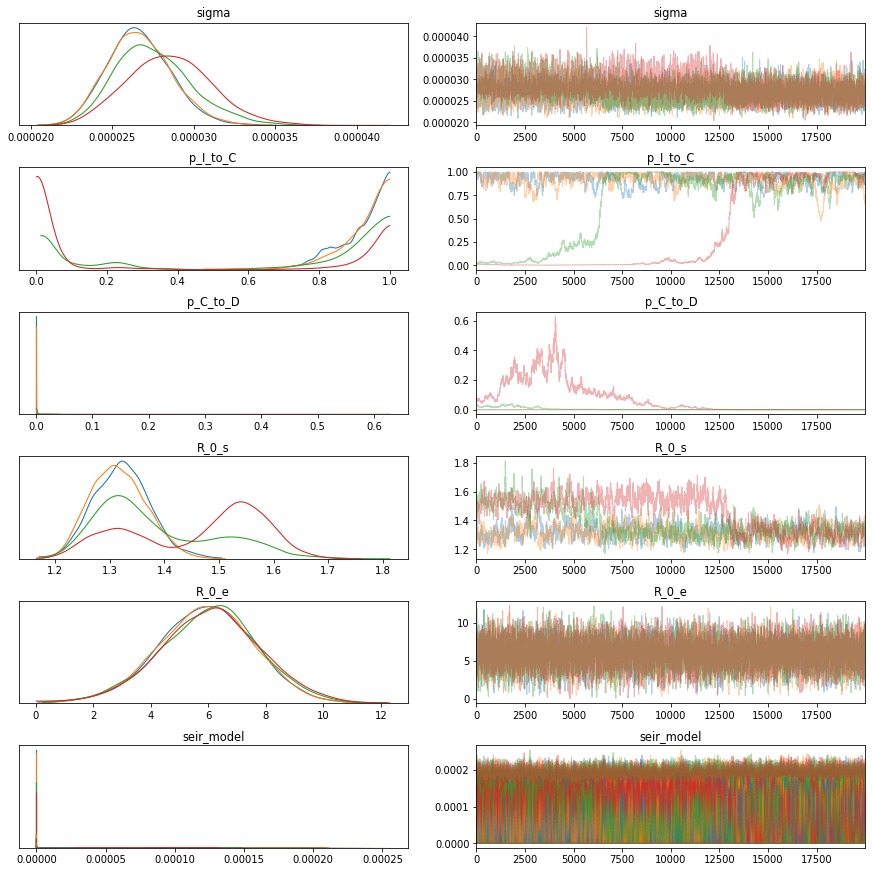

In [109]:
pm.traceplot(seir_trace);